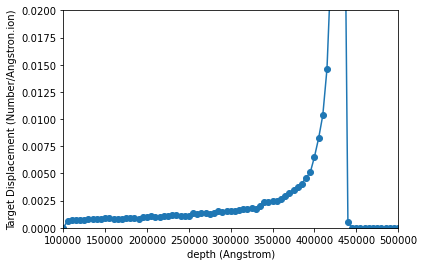

272.25537499999996 displacements/ion


In [236]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import integrate

def gen_latex_table(table,energies):
    print(r"\begin{table}[]" + "\n" + r"\resizebox{10.0cm}{!}{" + "\n" + r"\begin{tabular}{|l|c|c|c|c|c|c|c|c|c|c|c|c|c|}" + "\n\hline\n")
    header = "Element"
    for i in energies:
        header += r" & ${0} \ MeV$".format(i)
    print(header + r" \\" )
    print(r"\hline")
    for j in table:
        #j = j.replace("$1000.0^{\circ}$", "-")
        #j = j.replace("$-100.0\%$","-")
        #j = j.replace("$-1.0E+07$","-")
        #j = j.replace("E","x10^{")
        #j = j.replace("$-10000.0$", "-")
        print(j)
    print("\hline\n \end{tabular} \n } \n \end{table}")
    

def format_table(file,init,end):
    lines_data = []
    for i, line in enumerate(file):
        if i in np.arange(init, end): 
            lines_data.append(line) 
    data_array = np.loadtxt(lines_data)
    return data_array

def dpa_vacancyCalc(file_path):
    """ Calculating the DPA throug the vacancy.txt """
    vacancy_file = open(file_path + "VACANCY.txt", 'r')
    repCol_file = open(file_path + "NOVAC.txt", 'r')
    vacancy_array = format_table(vacancy_file,init=34,end=134)
    repCol_array = format_table(repCol_file,init=29,end=129)
    target_displacement = np.add(vacancy_array[:,5], repCol_array[:,1])
    displacements_ion = dpa_calc(target_displacement,vacancy_array[:,0])
    return displacements_ion
    
def dpa_energyMet1(file_path):
    """ Calculating the DPA throug the T_dam = E_recoil - E_ionizr """
    e2recoil_file = open(file_path + "E2RECOIL.txt", 'r')
    ionization_file = open(file_path + "IONIZ.txt", 'r')
    e2recoil_array = format_table(e2recoil_file, init=,end=) # missing input
    ionization_array = format_table(ionization_file, init=,end=)
    T_dam = np.subtract(e2recoil_array[:,5], ionization_array[;,2])
    dpa_depth = dpa_depth(T_dam)
    displacements_ion = dpa_calc(dpa_depth,e2recoil_array[:,0])
    return displacements_ion
    
def dpa_energyMet2(file_path):
    """ Calculating the DPA through the T_dam = E_phr - E_phi """
    phonons_file = open(file_path + "PHONONS.txt", 'r')
    phonons_array = format_table(phonons_file, init=,end=)
    T_dam = np.subtract(phonons_array[:,2],phonons_array[:,1])
    dpa_depth = dpa_depth(T_dam)
    displacements_ion = dpa_calc(dpa_depth,phonons_array[:,0])
    return displacements_ion
    
def dpa_depth(T_dam,E_d=33):
    T_dam = list(T_dam)
    dpa_depth = []
    for i in range(len(T_dam)):
        dpa = (0.8*T_dam[i])/(2*E_d)
        dpa_depth.append(dpa)
    return dpa_depth
    
def dpa_calc(y,x):
    # Get only data from 10um to 34 um.
    i = 0
    new_x = []
    new_y = []
    while(i < len(x)):
        if (x[i] > 1e5) and (x[i] <= 3.4e5): # get the epitaxial layer region
            #print(yeap)
            new_x.append(x[i])
            new_y.append(y[i])
        i += 1
    #now integrate 
    dpa = integrate.simpson(new_y,new_x)
    return dpa
    
#ions = ["H", "He", "Li" ,"Be", "B", "C", "N", "O", "F", "Ne"]
#energies = [4.0,8.0,10.0,15.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0] # MeV

ions = ["Be"]
energies = [30.0] # MeV
nEvents=100

table_dpaVac = []
table_dpaEn1 = []
tabel_dpaEn2 = []

def plot(x,y):
    plt.plot(x,y)
    plt.scatter(x,y)
    plt.xlabel("depth (Angstrom)")
    plt.ylabel("Target Displacement (Number/Angstron.ion)")
    plt.ylim(0,0.02)
    plt.xlim(1e5,5e5)
    plt.show()
    
for ion in ions:
    table_dpaVac += "& " + ion
    table_dpaEn1 += "& " + ion
    tabel_dpaEn2 += "& " + ion
    for energy in energies:
        file_path = "TRIM_outputs/{0}_{1}_MeV_n{2}/".format(ion,energy,nEvents)
        try:
            vacancy_file = open(file_path + "VACANCY.txt", 'r')
            repCol_file = open(file_path + "NOVAC.txt", 'r')
            dpa_vacancy = int(dpa_vacancyCalc(file_path))
            dpa_energy1 = int(dpa_energyMet1(file_path))
            dpa_energy2 = int(dpa_energyMet2(file_path))
            table_dpaVac += " & {0}".format(dpa_vacancy)
            table_dpaEn1 += " & {0}".format(table_dpaEn1) 
            tabel_dpaEn2 += " & {0}".format(tabel_dpaEn2)
            print("{0} displacements/ion".format(dpa_vacancy))
        except:
            #print("Not found data for {0} {1} MeV".format(ion,energy))
            pass
    table_dpaVac += r" \\"
    table_dpaEn1 += r" \\"
    tabel_dpaEn2 += r" \\"
    
print("------------------Tables-------------------")
print("------------------DPA - VACANCY.txt-------------------") 
gen_latex_table(table_dpaVac,energies)
print("------------------DPA - ENERGY METHOD 1-------------------")
gen_latex_table(table_dpaEn1,initial_energy)
print("------------------DPA - ENERGY METHOD 2----------------------")
gen_latex_table(table_dpaEn2,initial_energy)
print("End of Program")
        